In [2]:
import xarray as xr
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt

# Latex points to inches conversion factor
PTS_PER_INCH = 72.26999
# Latex text width in points
TEXT_WIDTH_PTS = 505.12177
# Latex column width in points
COLUMN_WIDTH_PTS = TEXT_WIDTH_PTS / 2
# Latex column width in inches
COLUMN_WIDTH_INCHES = COLUMN_WIDTH_PTS / PTS_PER_INCH
# Latex text width in inches
TEXT_WIDTH_INCHES = TEXT_WIDTH_PTS / PTS_PER_INCH
# DPI for figures
DPI = 600
# Font scale for figures
FONT_SCALE = 0.5

plt.rcParams['font.stretch'] = 'condensed'
plt.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('xtick', labelsize=8) 
matplotlib.rc('ytick', labelsize=8) 

def plot_signal(ds: xr.Dataset, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(ds['time'], ds['data'])
    ax.set_ylabel(f"{ds.attrs['units']}")
    ax.set_title(f'{ds.label}', fontsize=8)

def standardise_names(ds: xr.Dataset) -> xr.Dataset:
    for name in ['t', 'time1']:
        if name in ds:
            ds = ds.rename({name: 'time'})

    return ds

In [8]:
data_path = Path('~/data/tiny').expanduser()
shot_files = list(data_path.glob('*.zarr'))
shot_file = shot_files[4]


defuse_signals = [
    'amc/plasma_current',
    'ayc/te_core',
    'xdc/ip_t_ipref',
    'esm/v_loop_dynamic', 
    'efm/li',
    'efm/magnetic_axis_z', 
    'efm/plasma_area', 
    'esm/surface_area', 
    'efm/minor_radius', 
    'efm/geom_axis_rc', 
    'efm/elongation'
]

datasets = {name:  xr.open_dataset(shot_file, group=name) for name in defuse_signals}
datasets = {name: standardise_names(ds) for name, ds in datasets.items()}

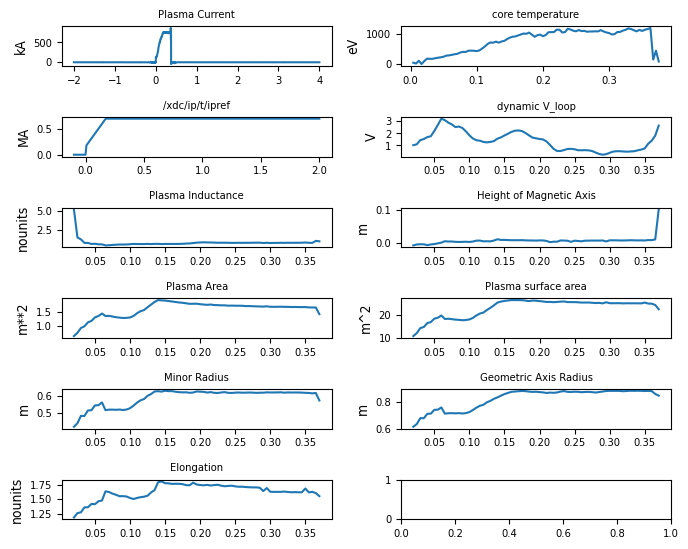

In [9]:
fig, axes = plt.subplots(6, 2, figsize=(TEXT_WIDTH_INCHES, TEXT_WIDTH_INCHES*.8))
for name, ax in zip(defuse_signals, axes.flatten()):
    plot_signal(datasets[name], ax=ax)

plt.tight_layout()